In [50]:
from matplotlib import pyplot as plt

def display_image(img):
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


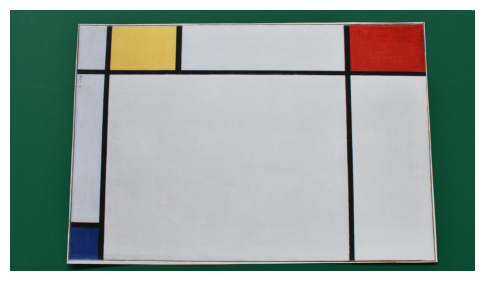

In [51]:
import cv2 as cv

data_path = r'C:\workspace\evml\EVD3\workspace\data\mondriaan1 (1).JPG'

img = cv.imread(data_path)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

display_image(img_rgb)

In [52]:
def maskColor(img, min_hue, max_hue, invert=False):
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    
    light = (min_hue,50,50)
    dark  = (max_hue,255,255)

    mask = cv.inRange(img_hsv, light, dark)
    
    if invert:
        mask = cv.bitwise_not(mask)

    return mask

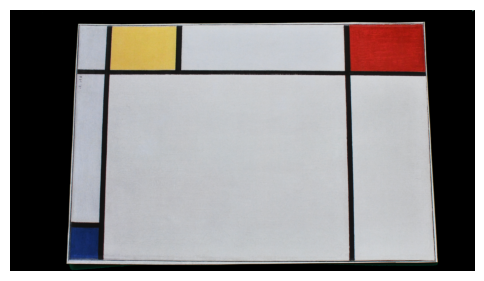

In [68]:
mask = maskColor(img_rgb, 67, 82, True)
masked_img = cv.bitwise_and(img_rgb, img_rgb, mask=mask)

display_image(masked_img)

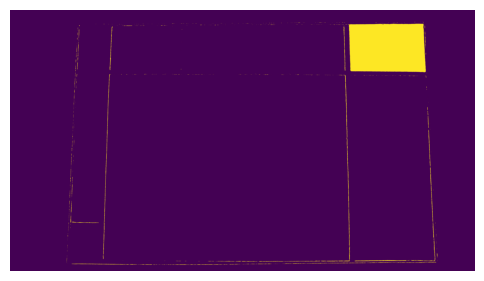

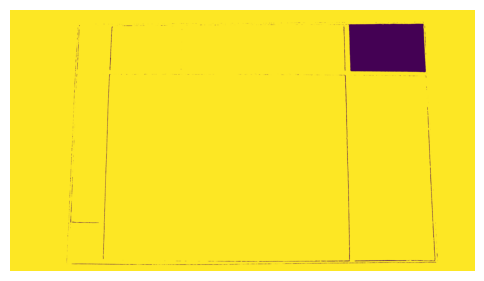

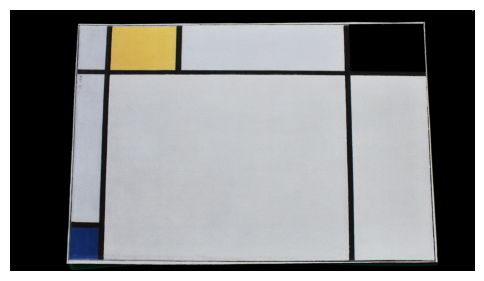

In [69]:
mask_upper = maskColor(img_rgb, 0, 11, False)
mask_lower = maskColor(img_rgb, 169, 180, False)
red_mask = cv.bitwise_or(mask_upper, mask_lower)

display_image(red_mask)

not_red_mask = cv.bitwise_not(red_mask)

display_image(not_red_mask)

img_no_red = cv.bitwise_and(masked_img, masked_img, mask=not_red_mask)

display_image(img_no_red)

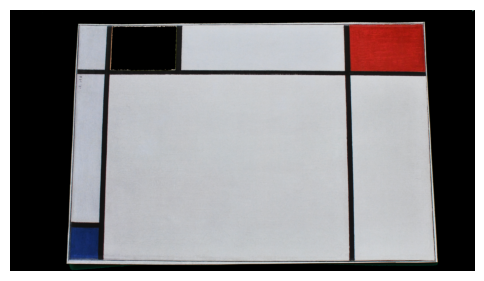

In [ ]:
yellow_mask = maskColor(img_rgb, 20, 30, False)
not_yellow_mask = cv.bitwise_not(yellow_mask)
img_no_yellow = cv.bitwise_and(masked_img, masked_img, mask=not_yellow_mask)

display_image(img_no_yellow)

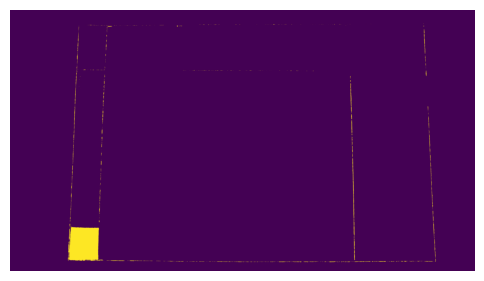

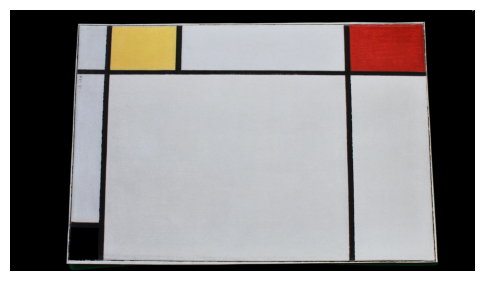

In [ ]:
blue_mask = maskColor(img_rgb, 100, 130, False)
not_blue_mask = cv.bitwise_not(blue_mask)
img_no_blue = cv.bitwise_and(masked_img, masked_img, mask=not_blue_mask)

display_image(img_no_blue)

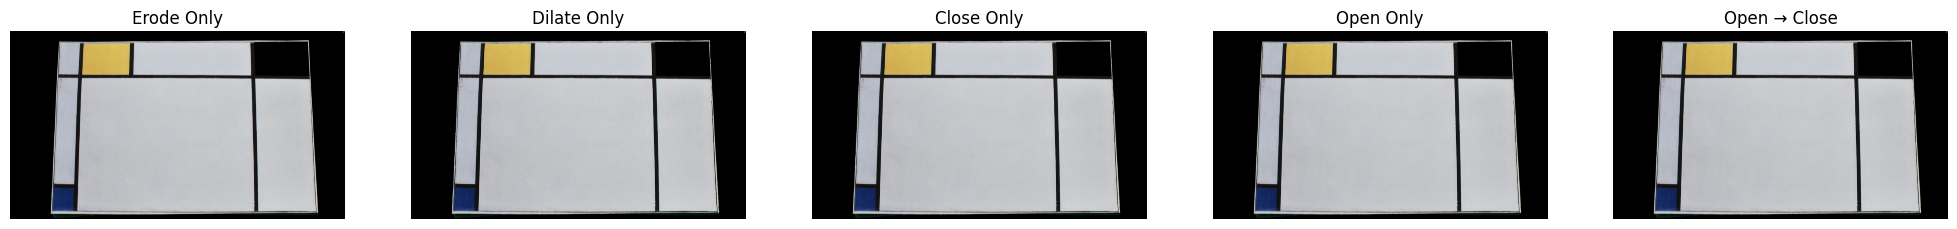

In [70]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

kernel = np.ones((3, 3), np.uint8)

# --- 1. Erode only ---
red_mask_erode = cv.erode(red_mask, kernel, iterations=1)
not_red_erode = cv.bitwise_not(red_mask_erode)
img_no_red_erode = cv.bitwise_and(masked_img, masked_img, mask=not_red_erode)

# --- 2. Dilate only ---
red_mask_dilate = cv.dilate(red_mask, kernel, iterations=1)
not_red_dilate = cv.bitwise_not(red_mask_dilate)
img_no_red_dilate = cv.bitwise_and(masked_img, masked_img, mask=not_red_dilate)

# --- 3. Close only ---
red_mask_close = cv.morphologyEx(red_mask, cv.MORPH_CLOSE, kernel)
not_red_close = cv.bitwise_not(red_mask_close)
img_no_red_close = cv.bitwise_and(masked_img, masked_img, mask=not_red_close)

# --- 4. Open only ---
red_mask_open = cv.morphologyEx(red_mask, cv.MORPH_OPEN, kernel)
not_red_open = cv.bitwise_not(red_mask_open)
img_no_red_open = cv.bitwise_and(masked_img, masked_img, mask=not_red_open)

# --- 5. Open → Close ---
red_mask_open_close = cv.morphologyEx(red_mask, cv.MORPH_OPEN, kernel)
red_mask_open_close = cv.morphologyEx(red_mask_open_close, cv.MORPH_CLOSE, kernel)
not_red_open_close = cv.bitwise_not(red_mask_open_close)
img_no_red_open_close = cv.bitwise_and(masked_img, masked_img, mask=not_red_open_close)

# --- Display all variants ---
fig, axes = plt.subplots(1, 5, figsize=(25, 6))

axes[0].imshow(img_no_red_erode)
axes[0].set_title("Erode Only")
axes[0].axis('off')

axes[1].imshow(img_no_red_dilate)
axes[1].set_title("Dilate Only")
axes[1].axis('off')

axes[2].imshow(img_no_red_close)
axes[2].set_title("Close Only")
axes[2].axis('off')

axes[3].imshow(img_no_red_open)
axes[3].set_title("Open Only")
axes[3].axis('off')

axes[4].imshow(img_no_red_open_close)
axes[4].set_title("Open → Close")
axes[4].axis('off')

plt.show()


In [56]:
def color_percentage(mask):
    """Calculate % of pixels in mask"""
    total_pixels = mask.size
    color_pixels = cv.countNonZero(mask)
    return (color_pixels / total_pixels) * 100

In [74]:
print("red color percentages:")
print(color_percentage(red_mask_erode))
print(color_percentage(red_mask_dilate))
print(color_percentage(red_mask_open))
print(color_percentage(red_mask_close))
print(color_percentage(red_mask_open_close))

print(f"yellow color percentages: {color_percentage(yellow_mask)}")

print(f"blue color percentages: {color_percentage(blue_mask)}")


red color percentages:
3.0669637607666753
3.714187253799571
3.261926022282976
3.3921573220742567
3.2705097359408533
yellow color percentages: 2.3332313622600465
blue color percentages: 1.0482867481700326


In [81]:
def create_hue_histogram(img: np.ndarray, s_threshold: int = 30, v_threshold: int = 30, center_hue: int = -1) -> np.ndarray:
    """
    Create a meaningful hue histogram from an OpenCV image, excluding pixels with low saturation or value,
    with an option to center a specific hue.

    This function converts the input image to HSV color space, applies thresholds to exclude pixels
    with low saturation or value (which have meaningless hue), and then creates a histogram of the
    hue values for the remaining pixels.

    Args:
        img (np.ndarray): Input image in BGR format (OpenCV default).
        s_threshold (int, optional): Minimum saturation for a pixel to be included. Defaults to 30.
        v_threshold (int, optional): Minimum value for a pixel to be included. Defaults to 30.
        center_hue (int, optional): Hue value to center the histogram on. Range 0-179. 
                                    Default is -1 (no centering).        

    Returns:
        np.ndarray: The normalized hue histogram.    

    Note:
        - The function assumes the input image is in BGR format (OpenCV default).
        - The histogram is normalized to the range [0, 1].
        - Hue values in OpenCV range from 0 to 179 (for 8-bit images).
    """
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    h, s, v = cv.split(hsv)

    # Shift hue if center_hue is specified
    if 0 <= center_hue <= 179:
        h = (h - center_hue + 90) % 180    

    # Create a mask for meaningful colors
    mask = cv.bitwise_and(cv.inRange(s, s_threshold, 255), cv.inRange(v, v_threshold, 255))
    
    # Calculate histogram for masked hue values
    hist = cv.calcHist([h], [0], mask, [180], [0, 180])

    # Normalize the histogram
    cv.normalize(hist, hist, 0, 1, cv.NORM_MINMAX)    
    
    return hist

In [82]:
from matplotlib.colors import hsv_to_rgb

def plot_hue_histogram(hist: np.ndarray, center_hue: int = -1):
    """
    Plot a hue histogram with a color chart along the x-axis.

    Args:
        hist (np.ndarray): The hue histogram to plot.
        center_hue (int, optional): The hue value the histogram is centered on. 
                                    Default is -1 (no centering).
    """
    fig, (ax_hist, ax_color) = plt.subplots(2, 1, figsize=(10, 6), 
                                            gridspec_kw={'height_ratios': [4, 1]}, 
                                            sharex=True)
    
    # Plot the histogram
    ax_hist.plot(hist.ravel())
    ax_hist.set_title('Hue Histogram')
    ax_hist.set_ylabel('Frequency')
    ax_hist.set_xlim([0, 180])
    
    # Create a color array for the colorbar
    hue_range = np.linspace(0, 1, 180)
    saturation = np.ones_like(hue_range)
    value = np.ones_like(hue_range)
    hsv_colors = np.stack((hue_range, saturation, value), axis=1)
    rgb_colors = hsv_to_rgb(hsv_colors)
    
    # Plot the color chart
    ax_color.imshow([rgb_colors], aspect='auto', extent=[0, 180, 0, 1])
    ax_color.set_yticks([])
    
    # Set x-axis label
    plt.xlabel('Hue Value' + (' (Shifted)' if 0 <= center_hue <= 179 else ''))
    
    plt.tight_layout()
    plt.show()

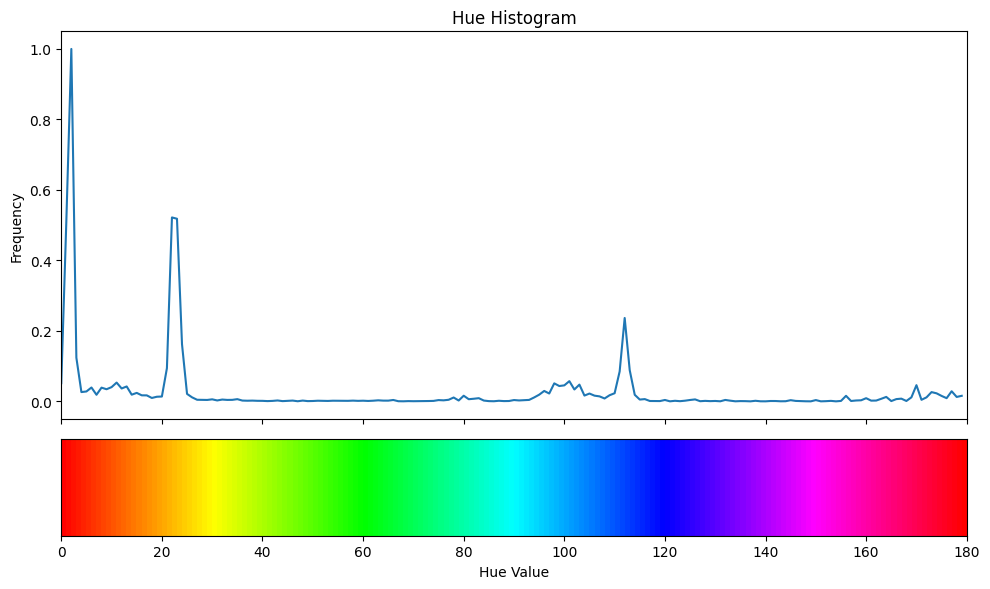

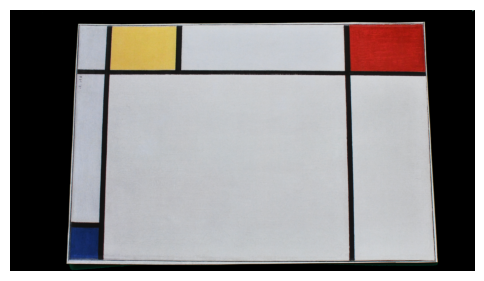

In [83]:
hist = create_hue_histogram(masked_img)
plot_hue_histogram(hist)
display_image(masked_img)

In [85]:
import numpy as np
import cv2 as cv

# Convert to float to avoid integer division
img_float = masked_img.astype(np.float32)

# Sum of all channels per pixel
sum_channels = img_float.sum(axis=2, keepdims=True)  # shape (H, W, 1)
# Avoid division by zero
sum_channels[sum_channels == 0] = 1

# Calculate ratios for each channel
ratios = img_float / sum_channels  # shape (H, W, 3), values in [0,1]

# Now calculate variance for each color ratio across all pixels
variance_per_channel = np.var(ratios.reshape(-1, 3), axis=0)  # [var_R, var_G, var_B]

print("Variance for Red ratio:", variance_per_channel[0])
print("Variance for Green ratio:", variance_per_channel[1])
print("Variance for Blue ratio:", variance_per_channel[2])


Variance for Red ratio: 0.027727602
Variance for Green ratio: 0.019129535
Variance for Blue ratio: 0.02683099


In [105]:
def center_of_mass(mask):
    """Compute the center of mass of a binary mask."""
    moments = cv.moments(mask)
    if moments["m00"] == 0:
        return None  # no pixels in mask
    cx = moments["m10"] / moments["m00"]
    cy = moments["m01"] / moments["m00"]
    return (int(cx), int(cy))

In [121]:
def distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

In [117]:
height, width = img_rgb.shape[:2]
image_center = (width//2, height//2)
image_diag = np.sqrt(width**2 + height**2)
print(height, width, image_center, image_diag)

3128 5568 (2784, 1564) 6386.470699846669


In [123]:
com_red = center_of_mass(red_mask)

print(com_red)

(4329, 671)


In [122]:
distance = distance(com_red, np.array(image_center))

normalized_distance = distance / image_diag

print(distance, normalized_distance)

1784.509456405317 0.27942028395247487


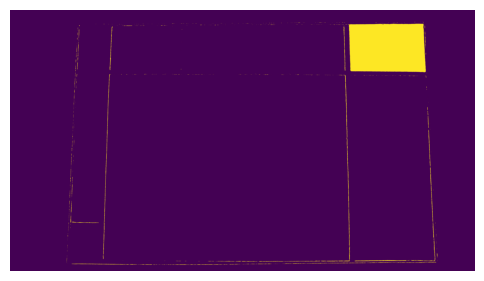

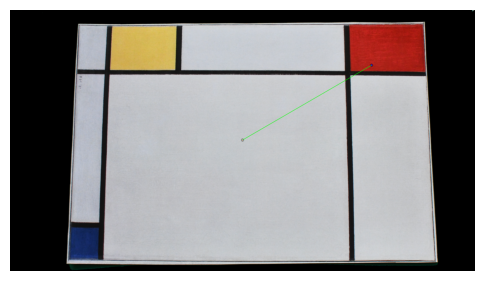

In [124]:
img_with_com = masked_img.copy()
cv.circle(img_with_com, com_red, radius=10, color=(0,0,255), thickness=-1)  # BGR
cv.circle(img_with_com, com_red, radius=15, color=(0,0,0), thickness=2)    # black border
cv.circle(img_with_com, image_center, radius=5, color=(255,0,0), thickness=-1)  # blue dot
cv.circle(img_with_com, image_center, radius=15, color=(0,0,0), thickness=2)
cv.line(img_with_com, image_center, com_red, color=(0,255,0), thickness=3)
display_image(red_mask)
display_image(img_with_com)